In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
sys.executable

'c:\\Users\\denis\\anaconda3\\envs\\ucm\\python.exe'

# Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [3]:
from src.scrapper import scrape_nba_finals, scrape_NBA_team_data

# Get data

**Example NBA finals**

In [4]:
scrape_nba_finals()

,Year,Lg,Champion,Runner-Up,Finals MVP,,Points,Rebounds,Assists,Win Shares
0,2023,NBA,Denver Nuggets,Miami Heat,N. Jokić,,N. Jokić (600),N. Jokić (269),N. Jokić (190),N. Jokić (5.0)
1,2022,NBA,Golden State Warriors,Boston Celtics,S. Curry,,J. Tatum (615),A. Horford (214),J. Tatum (148),J. Butler (3.8)
2,2021,NBA,Milwaukee Bucks,Phoenix Suns,G. Antetokounmpo,,G. Antetokounmpo (634),G. Antetokounmpo (269),J. Holiday (199),G. Antetokounmpo (3.7)
3,2020,NBA,Los Angeles Lakers,Miami Heat,L. James,,A. Davis (582),L. James (226),L. James (184),A. Davis (4.5)
4,2019,NBA,Toronto Raptors,Golden State Warriors,K. Leonard,,K. Leonard (732),D. Green (223),D. Green (187),K. Leonard (4.9)
5,2018,NBA,Golden State Warriors,Cleveland Cavaliers,K. Durant,,L. James (748),D. Green (222),L. James (198),L. James (5.2)
6,2017,NBA,Golden State Warriors,Cleveland Cavaliers,K. Durant,,L. James (591),K. Love (191),L. James (141),L. James (4.3)
7,2016,NBA,Cleveland Cavaliers,Golden State Warriors,L. James,,K. Thompson (582),D. Green (228),R. Westbrook (198),L. James (4.7)
8,2015,NBA,Golden State Warriors,Cleveland Cavaliers,A. Iguodala,,L. James (601),D. Howard (238),L. James (169),S. Curry (3.9)
9,2014,NBA,San Antonio Spurs,Miami Heat,K. Leonard,,K. Durant (563),T. Duncan (211),R. Westbrook (153),L. James (4.3)


**Example team season**

In [2]:
year = 2022

# URL to scrape, notice f string:
url = f"https://www.basketball-reference.com/leagues/NBA_{year}_standings.html"

# collect HTML data
html = urlopen(url)

# create beautiful soup object from HTML
soup = BeautifulSoup(html, features="html.parser")

# use getText()to extract the headers into a list
titles = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]

# first, find only column headers
headers = titles[1:titles.index("SRS")+1]

# then, exclude first set of column headers (duplicated)
titles = titles[titles.index("SRS")+1:]

In [3]:
try:
    row_titles = titles[0:titles.index("Eastern Conference")]
except: row_titles = titles

# remove the non-teams from this list
for i in headers:
    row_titles.remove(i)

divisions = ["Atlantic Division", "Central Division",
                "Southeast Division", "Northwest Division",
                "Pacific Division", "Southwest Division",
                "Midwest Division"]

[row_titles.remove(x) for x in row_titles if x in divisions ]

# Separate east and west 
east_titles = row_titles[:row_titles.index('Western Conference')]
west_titles = row_titles[row_titles.index('Western Conference')+1:]

row_titles.remove("Western Conference")


In [5]:
rows = soup.findAll('tr')[1:]

In [7]:
team_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

In [9]:
# remove empty elements
team_stats = [e for e in team_stats if e != []]

# only keep needed rows
team_stats = team_stats[0:len(row_titles)]

In [12]:
len(team_stats)

30

In [13]:
for i in range(0, len(team_stats)):
    team_stats[i].insert(0, row_titles[i])
    team_stats[i].insert(0, year)
    
# add team, year columns to headers
headers.insert(0, "Team")
headers.insert(0, "Year")

In [15]:
final_df = pd.DataFrame(columns = ["Year", "Team", "W", "L",
                                       "W/L%", "GB", "PS/G", "PA/G",
                                       "SRS", "Playoffs",
                                       "Losing_season"])
    

In [16]:
# create a dataframe with all aquired info
year_standings = pd.DataFrame(team_stats, columns = headers)

# add a column to dataframe to indicate playoff appearance
year_standings["Playoffs"] = ["Y" if "*" in ele else "N" for ele in year_standings["Team"]]
# remove * from team names
year_standings["Team"] = [ele.replace('*', '') for ele in year_standings["Team"]]
# add losing season indicator (win % < .5)
year_standings["Losing_season"] = ["Y" if float(ele) < .5 else "N" for ele in year_standings["W/L%"]]

# append new dataframe to final_df
final_df = pd.concat([final_df, year_standings], ignore_index=True)

In [21]:
east_titles = [e.replace('*','') for e in east_titles] 

In [22]:
east_df = final_df[final_df.Team.isin(east_titles)].sort_values(by='W',ascending=False)


In [23]:
east_df

,Year,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season
0,2022,Miami Heat,53,29,.646,—,110.0,105.6,4.23,Y,N
1,2022,Boston Celtics,51,31,.622,2.0,111.8,104.5,7.02,Y,N
2,2022,Milwaukee Bucks,51,31,.622,2.0,115.5,112.1,3.22,Y,N
3,2022,Philadelphia 76ers,51,31,.622,2.0,109.9,107.3,2.57,Y,N
4,2022,Toronto Raptors,48,34,.585,5.0,109.4,107.1,2.38,Y,N
5,2022,Chicago Bulls,46,36,.561,7.0,111.6,112.0,-0.38,Y,N
6,2022,Brooklyn Nets,44,38,.537,9.0,112.9,112.1,0.82,Y,N
7,2022,Cleveland Cavaliers,44,38,.537,9.0,107.8,105.7,2.04,N,N
8,2022,Atlanta Hawks,43,39,.524,10.0,113.9,112.4,1.55,Y,N
9,2022,Charlotte Hornets,43,39,.524,10.0,115.3,114.9,0.53,N,N


In [17]:
final_df

,Year,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season
0,2022,Miami Heat,53,29,.646,—,110.0,105.6,4.23,Y,N
1,2022,Boston Celtics,51,31,.622,2.0,111.8,104.5,7.02,Y,N
2,2022,Milwaukee Bucks,51,31,.622,2.0,115.5,112.1,3.22,Y,N
3,2022,Philadelphia 76ers,51,31,.622,2.0,109.9,107.3,2.57,Y,N
4,2022,Toronto Raptors,48,34,.585,5.0,109.4,107.1,2.38,Y,N
5,2022,Chicago Bulls,46,36,.561,7.0,111.6,112.0,-0.38,Y,N
6,2022,Brooklyn Nets,44,38,.537,9.0,112.9,112.1,0.82,Y,N
7,2022,Cleveland Cavaliers,44,38,.537,9.0,107.8,105.7,2.04,N,N
8,2022,Atlanta Hawks,43,39,.524,10.0,113.9,112.4,1.55,Y,N
9,2022,Charlotte Hornets,43,39,.524,10.0,115.3,114.9,0.53,N,N


In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import requests
from PIL import Image
from io import BytesIO

In [2]:
def get_player_image(player):
    """ Return first result of google images for indicated player """

    url = f'https://www.google.com/search?q={player}&tbm=isch'
    content = requests.get(url).content
    soup = BeautifulSoup(content,'lxml')
    images = soup.findAll('img')
    final_url = images[1].get('src')
    im = Image.open(requests.get(final_url, stream=True).raw)
    # im = im.resize((300, 300))
    return im

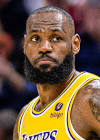

In [3]:
get_player_image('Lebron James')

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from src.scrapper import get_stats

In [34]:
def get_player_stats(player,season):

    """ Get player stats indicating name and season (year)"""

    url = f'https://www.basketball-reference.com/leagues/NBA_{season}_per_game.html'

    table_html = BeautifulSoup(urlopen(url),'html.parser').findAll('table')

    df = pd.read_html(str(table_html))[0]
    
    df = df[df.Player.apply(lambda x: x.lower()) == player.lower()]

    final_cols = ['Age', 'Tm','G','PTS','AST', 'TRB', 'STL','BLK','TOV',
                    'MP','FG%','3P%', '2P%', 'eFG%','FT%','PF','Player']
    
    df_player = df[final_cols].set_index('Player').T.reset_index()

    return df_player

In [36]:
player_1_df = get_player_stats('Lebron James',2022)

In [37]:
player_2_df= get_player_stats('Stephen Curry',2022)

In [48]:
players_df = player_1_df.merge(player_2_df,on='index').set_index('index').T
players_df

index,Age,Tm,G,PTS,AST,TRB,STL,BLK,TOV,MP,FG%,3P%,2P%,eFG%,FT%,PF
Player,,,,,,,,,,,,,,,,
LeBron James,37,LAL,56,30.3,6.2,8.2,1.3,1.1,3.5,37.2,.524,.359,.620,.590,.756,2.2
Stephen Curry,33,GSW,64,25.5,6.3,5.2,1.3,0.4,3.2,34.5,.437,.380,.527,.554,.923,2.0


In [49]:
players_df = players_df[['PTS','AST','TRB','STL','BLK','TOV','MP','PF']]


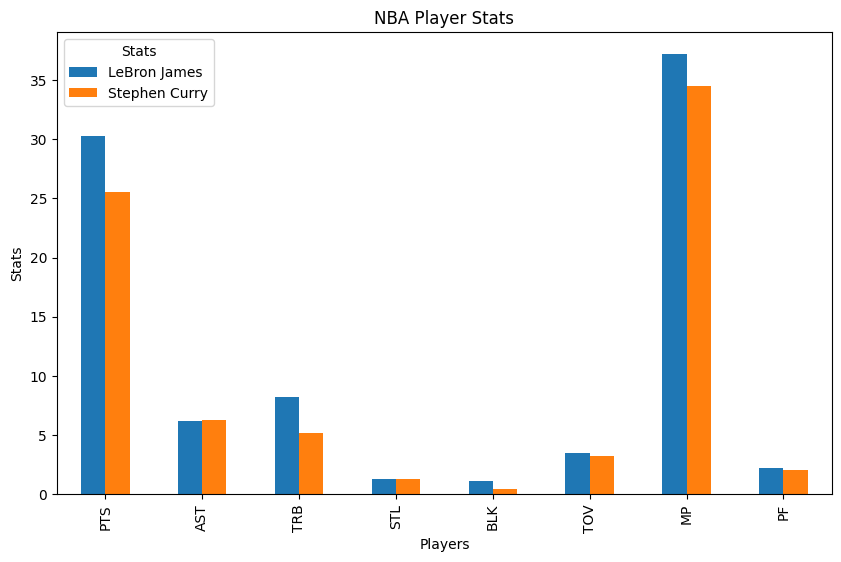

In [52]:
players_df = players_df.apply(pd.to_numeric, errors='coerce')

players_df.T.plot(kind='bar', figsize=(10, 6))
plt.title('NBA Player Stats')
plt.xlabel('Players')
plt.ylabel('Stats')
plt.legend(title='Stats')
plt.show()

